In [1]:
import sklearn.metrics as skm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis_utils import *
from nlp_synt_data import *
from data.texts import *
from data.training import *
from sc import *

In [23]:
# different lengths of text
[len(t[0]) for t in JOBS_SPLIT_v0_n0]
def text_maker(texts:list[tuple[str,str]], n_chars):
    res = []
    new_text = ""
    new_label = "INCLUSIVO"
    for text,label in texts:
        if label == "TODO":
            new_label = label
        new_text += "\n" + text
        if len(new_text) > n_chars:
            res.append((new_text,new_label))
            new_text = ""
            new_label = "INCLUSIVO"
    if new_text != "":
        res.append((new_text,new_label))
        new_text = ""
        new_label = "INCLUSIVO"
    return res

print(text_maker(JOBS_SPLIT_v0_n1, 800)[0][0])
print(text_maker(JOBS_SPLIT_v0_n1, 800)[1][0])



Siamo ansiosi di conoscerti e di esplorare come le tue competenze e la tua esperienza possano contribuire al nostro team!
Siamo alla ricerca di [JOB] per una prestigiosa realtà del settore bancario con sede in provincia di Bergamo. 
Requisiti richiesti: 
- Diploma di scuola superiore e/o laurea in discipline economiche o finanziarie 
- Esperienza pregressa nel ruolo di [JOB] allo sportello bancario 
- Capacità di gestire le operazioni di cassa, inclusi pagamenti, prelievi e depositi 
- Conoscenza dei principali strumenti informatici e software bancari 
- Capacità di lavorare in autonomia e di gestire situazioni di stress 
- Ottime capacità comunicative e relazionali 
- Precisione e attenzione ai dettagli Responsabilità: 
- Gestione delle operazioni di cassa, inclusi pagamenti, prelievi e depositi 

- Accoglienza e assistenza ai clienti presso lo sportello bancario 
- Fornire informazioni sui prodotti e servizi bancari 
- Promuovere e vendere prodotti e servizi finanziari 
- Mantenere 

In [2]:
df = pd.read_json('data/dbdump_testdb.jobs_v5.json')
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
# df = df[df['company'].str.contains('ecco')]
# df['description'].unique().tolist()
df[df['description'].str.contains('contattato')]['description'].unique().tolist()

/var/folders/l9/p2tp5gr9171dtk7txwfptt100000gn/T/ipykernel_81810/683081029.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


["siamo alla ricerca di un/a operatore/operatrice addetto/a alla cassa e allo sportello bancario per una prestigiosa realtà del settore bancario con sede in provincia di bergamo. requisiti richiesti: - diploma di scuola superiore e/o laurea in discipline economiche o finanziarie - esperienza pregressa nel ruolo di cassiere/cassiera o addetto/addetta allo sportello bancario - capacità di gestire le operazioni di cassa, inclusi pagamenti, prelievi e depositi - conoscenza dei principali strumenti informatici e software bancari - capacità di lavorare in autonomia e di gestire situazioni di stress - ottime capacità comunicative e relazionali - precisione e attenzione ai dettagli responsabilità: - gestione delle operazioni di cassa, inclusi pagamenti, prelievi e depositi - accoglienza e assistenza ai clienti presso lo sportello bancario - fornire informazioni sui prodotti e servizi bancari - promuovere e vendere prodotti e servizi finanziari - mantenere la cassa in ordine e bilanciata ... co

In [3]:
df = pd.read_csv('data/job_description_seed_dataset_improved_context.csv')
df['len'] = df.apply(lambda x: len(x['text']), axis=1)
# df.sort_values('len', ascending=False, inplace=True)
# df[df['inclusive phrasing'] == 'NO'].head(100)['text'].iloc[14]
df.sort_values(by=['len'],ascending=False).head()['text'].to_list()
_map = {
    'YES': 'INCLUSIVO',
    'NO': 'NON INCLUSIVO'
}
df['label'] = df.apply(lambda x: _map[x['inclusive phrasing']], axis=1)
df[['text','label']].values.tolist()

#TEXT_SEED_v0()
df[(df['len'] >= 700) & (df['len'] <= 10000)]['text'].unique()

array(['In base al grade con il quale verrai assunto/a, Consultant/Senior Consultant avrai la possibilità di condividere la tua esperienza e le tue conoscenze con il team, iniziando a sviluppare capacità di leadership, e individuando la migliore soluzione occupandoti di: Interpretare proattivamente i bisogni del cliente, individuando metodologie e approcci coerenti Sviluppare e gestire iniziative e soluzioni in modo indipendente,  riorganizzazione aziendale o di ristrutturazione del debito finanziario.  Sviluppare iniziative e soluzioni in modo indipendente, raccogliendo e strutturando dati e svolgendo analisi a supporto delle decisioni di business.  Valorizzare il contributo delle risorse più Junior e contribuire alla loro crescita. Individuare potenziali rischi e criticità e condividerli tempestivamente con il resto del team. Collaborare efficacemente in team eterogenei ed internazionali. Grazie all’ufficio Learning avrai modo di seguire corsi e attività di formazione che ti permette

In [4]:
df = pd.read_csv('data/raw_data_finetune_train.csv')
df['text_JOB_value'] = df.apply(lambda x: x['text_JOB_value'] if isinstance(x['text_JOB_value'],str) else "", axis=1)
df['text_ADJ_value'] = df.apply(lambda x: x['text_ADJ_value'] if isinstance(x['text_ADJ_value'],str) else "", axis=1)
df['text_VERB_value'] = df.apply(lambda x: x['text_VERB_value'] if isinstance(x['text_VERB_value'],str) else "", axis=1)
df_jobs = df[df['text_JOB_value'] != ""]
df_adj = df[df['text_ADJ_value'] != ""]
df_verb = df[df['text_VERB_value'] != ""]
df_other = df[(df['text_JOB_value'] == "") & (df['text_ADJ_value'] == "") & (df['text_VERB_value'] == "")]
tot = len(df)
tot, len(df_jobs)/tot, len(df_adj)/tot, len(df_verb)/tot, len(df_other)/tot

(5712,
 0.49719887955182074,
 0.47058823529411764,
 0.012605042016806723,
 0.0196078431372549)

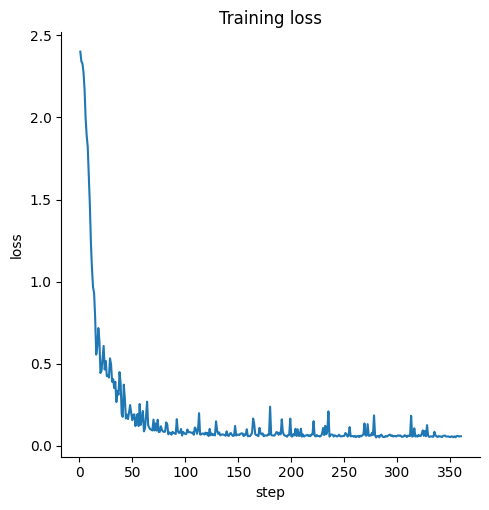

In [5]:
df_loss = pd.DataFrame({
    'step': [int(ln.split('	')[0]) for ln in TRAINING_LOSS.split('\n')],
    'loss': [float(ln.split('	')[1]) for ln in TRAINING_LOSS.split('\n')],
})
sns.relplot(data=df_loss, x='step', y='loss', kind='line')
plt.title('Training loss')
plt.show()

In [6]:
df = sc_df_finetuned_seed(remove_reinference=True)

In [7]:
df_res = df.copy()
df_res = df_res[df_res['prompt_id'] == "zsl#0"]
df_res = df_res[df_res['response'] != df_res['text_labels']]
df_res = split_by_len(df_res, groups=20)
df_res = df_res[(df_res['len'] >= 200) & (df_res['len'] <= 300)]
# df_res[['text_id','text_labels','response','text','response_text','true']]
df_res['text'].unique()

array(['#EquipePower Nel team troverai vari livelli di seniority, diversi background, accademici diverse età ma tutti accumunati dalla stessa voglia di mettersi in gioco e di rendere le ore di lavoro non solo proficue ma anche ingaggianti.',
       'Apri la tua carriera a nuovi scenari di crescita ed entra a far parte del team di EY Consulting. Tutte le nostre opportunità si rivolgono a persone L. 68/99 e prevedono una ricerca costante e continua dell’equilibrio di genere, abilità, esperienza e cultura.',
       'La tua candidatura verrà presa in carico da un Recruiter del nostro Team Talent Acquisition, che si occuperà di visionare il tuo CV e le informazioni fornite. Sarà poi il tuo Recruiter di riferimento a ricontattarti per condividere il nostro feedback per te.',
       'ATTIVITA’ DI COMUNICAZIONE; Coordinamento dell’agenzia di comunicazione e dei materiali di comunicazione in uscita (controllo piano editoriale, condivisione dei contenuti, aggiornamento sito internet); Attività d

phi3-finetuned
    count    %     df prompt_id           true
0  1208.0  1.0    raw     zsl#0      INCLUSIVO
0  1208.0  1.0  fixed     zsl#0      INCLUSIVO
0   542.0  1.0    raw     zsl#0  NON INCLUSIVO
0   542.0  1.0  fixed     zsl#0  NON INCLUSIVO


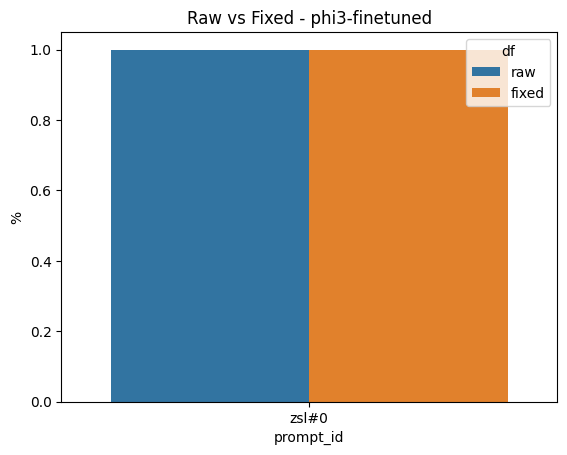

zsl#0
568 1152 30


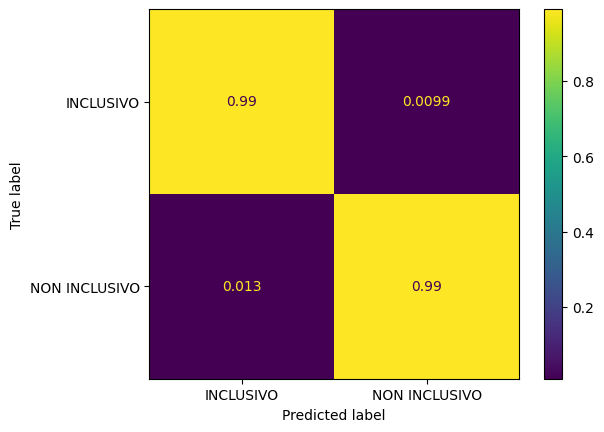

/Users/tommasoromano/Documents/websites/unimi-language-detection/analysis_utils.py:323: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])


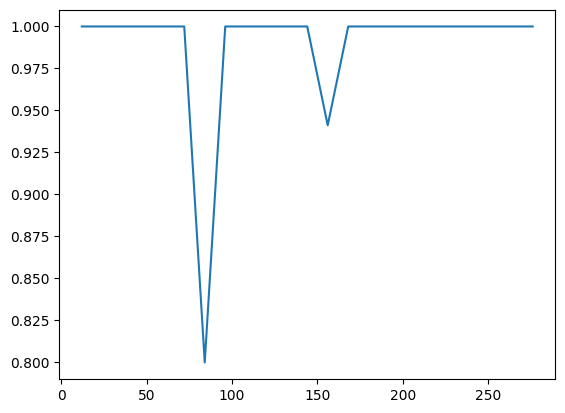

         name  pred/gt_pos%  pred/gt_neg%  precision  accuracy
0         all      0.995861      1.009225   0.994181  0.989143
0        jobs      1.002427      0.993590   0.985472  0.980634
0  adjectives      1.000000      1.000000   1.000000  1.000000
0      others      0.785714      4.000000   0.954545  0.733333


In [8]:
res_models_df = None

show_plots = True

for model in [
    'phi3-finetuned',
    # 'phi3',
    ]:
    print(model)
    df = pd.read_csv(f'results/{model}-eval-split-v0.csv')
    if model == 'phi3-finetuned':
        df = df[~df['response'].str.contains('NOT IN TEST DATASET')]
    df['text_id'] = df.apply(lambda x: x['text_id'] if x['text_id'][1] == '#' else "t" + x['text_id'][2:], axis=1)
    df['text'] = df.apply(lambda x: DataGenerator.get(x['text_id'],
                                                      #TEXT_SEED_v0(),
                                                    #   TEXT_JOB_ALL_v0,
                                                    TEXT_JOB_TEST_v0,
                                                      SUBS_JOBS_V0,
                                                      )['text'][0],
                        axis=1)
    # df = df[df['prompt_id'].str.contains('cot')]

    df_fix = fix_df(df, model, show_plot=show_plots)
    # df_fix

    # print(df_fix['true'].value_counts())
    # print(df_fix['response'].value_counts())

    #for p in df_fix['prompt_id'].unique():
    for p in [
        'zsl#0',
    ]:
        print(p)

        _df = df_fix[df_fix['prompt_id'] == p]

        df_len = split_by_len(_df, groups=20)

        if 'text_JOB_value' in _df.columns:
            df_jobs = _df[_df['text_JOB_value'] != ""]
            df_adj = _df[_df['text_ADJ_value'] != ""]
            if "text_VERB_value" in _df.columns:
                df_verb = _df[_df['text_VERB_value'] != ""]
                df_other = _df[(_df['text_JOB_value'] == "") & (_df['text_ADJ_value'] == "") & (_df['text_VERB_value'] == "")]
                print(len(df_jobs), len(df_adj), len(df_verb), len(df_other))
            else:
                df_other = _df[(_df['text_JOB_value'] == "") & (_df['text_ADJ_value'] == "")]
                print(len(df_jobs), len(df_adj), len(df_other))

        # sns.countplot(data=df_jobs, x='true')
        # plt.show()

        confusion_matrix(_df)

        analyze_len(df_len)

        df_metrics = metrics_of_dfs([
            (_df, "all"),
            (df_jobs,"jobs"),
            (df_adj,"adjectives"),
            # (df_verb,"verbs"),
            (df_other,"others"),
        ])
        print(df_metrics[['name','pred/gt_pos%','pred/gt_neg%','precision','accuracy']])
        if show_plots:
            plot_metrics(df_metrics, "phi3-finetuned")

        continue

        all = metrics(_df)
        all['name'] = 'all'
        res_df = pd.DataFrame(all, index=[0])
        all['name'] = model + " - " + p
        if res_models_df is None:
            res_models_df = pd.DataFrame(all, index=[0])
        else:
            res_models_df = pd.concat([res_models_df, pd.DataFrame(all, index=[0])])

        for __df, nm in [
            (df_jobs,"jobs"),
            (df_adj,"adjectives"),
            (df_verb,"verbs"),
            (df_other,"others"),
        ] if 'text_JOB_value' in _df.columns else []:
            print(nm)
            if len(__df) == 0:
                continue
            _metrics = metrics(__df)
            _metrics['name'] = nm
            res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(isin(df_jobs, NEUTRALS))
        # _metrics['name'] = 'neutrals'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # symbols = ['Ã',' e ',' o ','\*','/']
        # for s in symbols:
        #     _metrics = metrics(contains(df_jobs, [s]))
        #     _metrics['name'] = s
        #     res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(df_notjobs[df_notjobs['true'] == 'INCLUSIVO'])
        # _metrics['name'] = 'notjob_inclusive'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(df_notjobs[df_notjobs['true'] == 'NON INCLUSIVO'])
        # _metrics['name'] = 'notjob_not_inclusive'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(df_jobs[df_jobs['true'] == 'INCLUSIVO'])
        # _metrics['name'] = 'job_inclusive'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        # _metrics = metrics(df_jobs[df_jobs['true'] == 'NON INCLUSIVO'])
        # _metrics['name'] = 'job_not_inclusive'
        # res_df = pd.concat([res_df, pd.DataFrame(_metrics, index=[0])])

        if show_plots:
            print(res_df)
            plot_metrics(res_df, f" - {model} - {p}")

# print('all')
# plot_metrics(res_models_df, "- All models")
# res_models_df